# Data Analysis 

This notebook contains the data analysis steps to evaluate *Drosophila* data using the MARS tools.

All analysis is done in python3.

## Required modules and tools
#### From conda:
* ipython==4.2.0
* jupyter==1.0.0
* numpy==1.10.4
* pandas==0.17.1
* scipy==0.16.0
* seaborn==0.5.1
* matplotlib==1.4.3

#### From Bioconda
* gimmemotifs==0.8.5
* pybedtools==0.8.1

#### Non-python modules

* meme v4.11.1
* bedtools v2.24.0

# 1. Summary stats

Summarize the motif table to find transcription factors that have more than 10 motifs

Select the TFS that have  more than 10 motifs

In [3]:
#Set up the required directories
! [ ! -d Data ] && mkdir Data
! [ ! -d Results ] && mkdir Results
! [ ! -d Figures ] && mkdir Figures

In [1]:
# Import all the dependacies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from scipy.stats.mstats import winsorize
import scipy.stats
import numpy as np
from math import log
from scipy import stats
#import os moduls
import os
import glob

## Bioconda
import pybedtools

# MAke graphs appear in the notebook
%matplotlib inline

In [2]:
# Set global variables
# path to your genome
dm6 = "../genome/dm6.fa"

In [3]:
## Read the motifs data file
motif_table = pd.read_csv("../db-tables/dm-motif.tsv", sep = "\t", header = None)

# Get a snippet of the data
motif_table.head()
# Get info about your data
motif_table.info()
# Show structure of your data
motif_table.shape
# Set up column names
motif_table.columns = ["id", "motif_name", "Tf_name", "Collection_db", "Tf_id" ]
motif_table.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295 entries, 0 to 2294
Data columns (total 5 columns):
0    2295 non-null int64
1    2295 non-null object
2    2295 non-null object
3    2295 non-null object
4    2133 non-null object
dtypes: int64(1), object(4)
memory usage: 89.8+ KB


Index(['id', 'motif_name', 'Tf_name', 'Collection_db', 'Tf_id'], dtype='object')

In [4]:
# Summarize the TF ID column to get counts of motifs
#Check for null values in each column
#motif_table.isnull().sum()
# Drop null values as they are uncategorized motifs with no TF class
motif_table = motif_table.dropna()
motif_table.isnull().sum()

id               0
motif_name       0
Tf_name          0
Collection_db    0
Tf_id            0
dtype: int64

In [5]:
# Describe the TF id representation
motif_table['Tf_id'].describe()

# Get the counts of each representation
counts = motif_table['Tf_id'].value_counts().rename_axis('Tf_id').to_frame('counts') # Tf_id becomes the index
counts = motif_table['Tf_id'].value_counts().rename_axis('Tf_id').reset_index(name='counts')

# Get TF with over 10 motifs
over10motifs = counts[counts['counts'] >= 10]
over10motifs.shape

(56, 2)

In [6]:
#Get the TF table to extract tf names and join to the over 10 motifs
tf_table = pd.read_csv("../db-tables/Drosophila-TFs.tsv", sep = "\t", header = None)
tf_table.columns = ["Tf_id", "tf_name", "alt_name", "Tf_family" ]
tf_table =tf_table[["Tf_id", "tf_name"]]
# Chenge the int64 type to string in Tf_id
tf_table['Tf_id'] = tf_table.Tf_id.astype('str')

# Merge the file
over10motifs = pd.merge(over10motifs, tf_table, how = 'inner', left_on = ['Tf_id'], right_on = ['Tf_id'])
#Swap columns around
over10motifs = over10motifs.reindex(columns=["Tf_id", "tf_name", "counts"])
over10motifs.head(20)

,Tf_id,tf_name,counts
0,283,lola,46
1,13,da,32
2,513,brk,31
3,89,br,20
4,56,tgo,19
5,428,bcd,18
6,471,ems,17
7,430,cad,17
8,343,ttk,17
9,426,Abd-B,16


In [7]:
# select a tf to work on
# we will work on bcd
tf = 'Dfd'

# select the different tf names used on the different databases to a list
## Get the id of the tf name
idtf = over10motifs[over10motifs["tf_name"] == tf]
idtf = idtf ["Tf_id"].values[0]

# Get the motif names in the various data bases
get = motif_table[motif_table["Tf_id"] == idtf]
# Put the names in a list and retain the unique ones
motlist = get["Tf_name"].tolist()
motlist = list(set(motlist))
motlist

['Dfd']

In [8]:
# Define functions
def extract_meme_list(meme_in, out_meme, mot_list):
    """
    Use this to extract motifs in a given list from the main file. This differes
    from extract_scored since it does not add the scores of the motifs to the 
    meme header name
    """
    meme_head = """MEME version 4.4\n\nALPHABET= ACGT\n\nstrands: + -\n
Background letter frequencies (from uniform background):
A 0.25000 C 0.25000 G 0.25000 T 0.25000\n"""
    with open(out_meme, "w") as meme_out:
        meme_out.write(meme_head)
    for mot in mot_list:
        extract_meme_clean(meme_in, mot, out_meme)

def extract_meme_clean(meme_in, motif, meme_out):
    """
    Get the given motif from a meme file and writes to a meme file but without a meme heading
    """
    with open(meme_in) as f1:
        with open(meme_out, "a") as out_meme:
            lines = f1.readlines()
            for i, line in enumerate(lines):
                head = line.split()
                
                if motif in line:
                    # Sanity check
                    tag = False
                    if len(head) == 2 and motif == head[1]:
                        tag = True
                    if len(head) == 3 and motif == head[2]:
                        tag = True
                    if tag:
                        k = i
                        out_meme.write("\n"+lines[i].strip()+"\n\n")
                        if "log-odds" in lines[i+1]:
                            odds = lines[k+2].split()
                            for j in range(2, (int(odds[5])+3)*2):
                                out_meme.write(lines[i+j]),
                        elif "letter-probability" in lines[i+2]:
                            out_meme.write(lines[i+2])
                            odds = lines[k+2].split()
                            for j in range(0, (int(odds[5]))):
                                out_meme.write(lines[i+3+j])
                        elif "letter-probability" in lines[i+1]:
                            out_meme.write(lines[i+1])
                            odds = lines[k+1].split()
                            for j in range(0, (int(odds[5]))):
                                out_meme.write(lines[i+2+j])
                        else:
                            pass
                    else:
                        pass

In [9]:
# Get the meme file for the tf
meme_in = "Data/all_dm_motifs.meme"
out_meme = "Results/" + tf + ".meme"
motlist = motlist
extract_meme_list(meme_in, out_meme, motlist)

## CB-MAR: Tomtom demonstration

This section demonstrates the implementation of CB-MAR

### 1. First run tomtom pairwise comparison

We use bcd to demonstrate how the analysis is carried out.
The _**bcd.meme**_ file which we extracted above is in the **Results** directory.


In [10]:
## Ensure tomtom is in your path

meme_in = "Results/" + tf +".meme"
results_folder = "Results"
tf = tf
os.system(
    "tomtom -min-overlap 1 -dist %s -evalue -text -thresh 1000 -verbosity 1 %s %s >%s/%s_tomtom.txt" %
          ("ed", meme_in, meme_in, results_folder, tf))
# Remove the extra comment lines at the bottom when using meme v 5.1.1
f = open(results_folder+"/"+tf+"_tomtom.txt", "r")
tmp = f.readlines()

# Removee the last few lines which give the meme version and tom tom command used
with open(results_folder+"/"+tf+"_tomtom.txt", "w") as f:
    for line in tmp:
        if line.startswith("#"):
            continue
        else:
            f.write(line)

# Clean up the data and process it

In [11]:
infile = "Results/" + tf +"_tomtom.txt"
tomtom = pd.read_csv(infile,sep='\t')

# To avoid zezo division, use add the smallest possible value to each

tomtom["p-value"] += 0.000000000000000000000000000000000000000000000001

#Get the negative log of the p-value column
tomtom["p-value"] = -tomtom["p-value"].apply(log)

#Exatract the important columns to be used for any further analysis
tomtom = tomtom[["Query_ID", "Target_ID", "p-value"]]
#print(tomtom)
#Change the column names
## DO NOT USE this tomtom.columns = [["Query_ID", "Target_ID", "Score"]]
## When renaming columns, use DataFrame.columns = [list], not DataFrame.columns = [[list]]:
tomtom.columns = ["Query_ID", "Target_ID", "Score"]

#Piv0t the data into a pairwise matrix
#print (tomtom)
tomtom_matrix = tomtom.pivot(index="Query_ID", columns="Target_ID", values="Score")
tomtom_matrix

Target_ID,Dfd,Dfd_Cell_FBgn0000439,Dfd_FlyReg_FBgn0000439,Dfd_SOLEXA_FBgn0000439,M03784_2.00,M03785_2.00,M06226_2.00,M06227_2.00,M06228_2.00,M06481_2.00,M09675_2.00,M10784_2.00,MA0186.1
Query_ID,,,,,,,,,,,,,
Dfd,34.200705,6.089814,34.200705,7.321230,4.163553,7.188425,6.752539,20.134879,6.089814,7.310197,11.981209,4.729809,6.541384
Dfd_Cell_FBgn0000439,6.890652,31.451838,6.890652,9.016140,4.666358,10.214261,18.808860,5.801800,7.517882,14.818065,8.692428,3.435689,26.022490
Dfd_FlyReg_FBgn0000439,34.200705,6.089814,34.200705,7.321230,4.163553,7.188425,6.752539,20.134879,6.089814,7.310197,11.981209,4.729809,6.541384
Dfd_SOLEXA_FBgn0000439,6.983163,8.269462,6.983163,42.741619,9.467409,12.091664,11.058410,7.822952,22.741755,8.738931,10.772008,4.492136,6.327838
M03784_2.00,5.320346,4.555057,5.320346,11.497988,53.600310,13.991985,6.648002,6.749880,12.866439,5.355127,9.304721,6.183366,3.368017
M03785_2.00,7.026596,10.145287,7.026596,11.759193,11.423597,41.822553,13.758667,6.939820,10.145287,13.131959,9.897185,6.170352,9.311491
M06226_2.00,6.402553,16.957120,6.402553,10.339172,5.405526,12.121382,28.884419,6.581420,8.523614,23.455075,10.339172,4.228537,13.239487
M06227_2.00,20.541603,4.566690,20.541603,7.852911,5.280546,7.018990,6.683780,38.410887,7.729652,7.251044,12.941693,5.189761,4.872856
M06228_2.00,6.111776,6.694097,6.111776,23.548285,11.056431,10.462412,9.501682,7.957392,42.048470,7.364696,9.886969,4.046904,5.006302


### Reduce effect of extreme outliers by winzorizing the data

In [12]:
#convert the dataframe to an array the winsorize and finally convert back into a dataframe

tomtom_winz = pd.DataFrame(scipy.stats.mstats.winsorize(np.array(tomtom_matrix.values.T.tolist()),
                                                     limits=0.05), index=tomtom_matrix.index, columns=tomtom_matrix.columns)

tomtom_winz

Target_ID,Dfd,Dfd_Cell_FBgn0000439,Dfd_FlyReg_FBgn0000439,Dfd_SOLEXA_FBgn0000439,M03784_2.00,M03785_2.00,M06226_2.00,M06227_2.00,M06228_2.00,M06481_2.00,M09675_2.00,M10784_2.00,MA0186.1
Query_ID,,,,,,,,,,,,,
Dfd,34.200705,6.890652,34.200705,6.983163,5.320346,7.026596,6.402553,20.541603,6.111776,6.792286,11.245245,4.627087,7.280121
Dfd_Cell_FBgn0000439,6.089814,31.451838,6.089814,8.269462,4.555057,10.145287,16.957120,4.566690,6.694097,12.690062,7.730478,3.732940,25.329343
Dfd_FlyReg_FBgn0000439,34.200705,6.890652,34.200705,6.983163,5.320346,7.026596,6.402553,20.541603,6.111776,6.792286,11.245245,4.627087,7.280121
Dfd_SOLEXA_FBgn0000439,7.321230,9.016140,7.321230,34.200705,11.497988,11.759193,10.339172,7.852911,23.548285,8.131778,10.072553,3.943601,7.183581
M03784_2.00,4.163553,4.666358,4.163553,9.467409,34.200705,11.423597,5.405526,5.280546,11.056431,4.380316,7.617461,4.103099,3.732940
M03785_2.00,7.188425,10.214261,7.188425,12.091664,13.991985,34.200705,12.121382,7.018990,10.462412,11.228326,10.291011,4.599994,9.151647
M06226_2.00,6.752539,18.808860,6.752539,11.058410,6.648002,13.758667,28.884419,6.683780,9.501682,22.761926,10.212630,3.732940,14.163100
M06227_2.00,20.134879,5.801800,20.134879,7.822952,6.749880,6.939820,6.581420,34.200705,7.957392,6.989485,12.220210,5.069901,6.106319
M06228_2.00,6.089814,7.517882,6.089814,22.741755,12.866439,10.145287,8.523614,7.729652,34.200705,6.598911,8.767149,3.750640,5.859872


### Normalize the data by the maximum value

In [13]:
tomtom_normalized = tomtom_winz.div(tomtom_winz.max())
tomtom_normalized

Target_ID,Dfd,Dfd_Cell_FBgn0000439,Dfd_FlyReg_FBgn0000439,Dfd_SOLEXA_FBgn0000439,M03784_2.00,M03785_2.00,M06226_2.00,M06227_2.00,M06228_2.00,M06481_2.00,M09675_2.00,M10784_2.00,MA0186.1
Query_ID,,,,,,,,,,,,,
Dfd,1.000000,0.219086,1.000000,0.204182,0.155562,0.205452,0.221661,0.600619,0.178703,0.289587,0.328802,0.135292,0.279763
Dfd_Cell_FBgn0000439,0.178061,1.000000,0.178061,0.241792,0.133186,0.296640,0.587068,0.133526,0.195730,0.541037,0.226033,0.109148,0.973364
Dfd_FlyReg_FBgn0000439,1.000000,0.219086,1.000000,0.204182,0.155562,0.205452,0.221661,0.600619,0.178703,0.289587,0.328802,0.135292,0.279763
Dfd_SOLEXA_FBgn0000439,0.214067,0.286665,0.214067,1.000000,0.336192,0.343829,0.357950,0.229613,0.688532,0.346696,0.294513,0.115308,0.276053
M03784_2.00,0.121739,0.148365,0.121739,0.276819,1.000000,0.334016,0.187143,0.154399,0.323281,0.186753,0.222728,0.119971,0.143451
M03785_2.00,0.210184,0.324759,0.210184,0.353550,0.409114,1.000000,0.419651,0.205229,0.305912,0.478716,0.300901,0.134500,0.351682
M06226_2.00,0.197439,0.598021,0.197439,0.323339,0.194382,0.402292,1.000000,0.195428,0.277821,0.970448,0.298609,0.109148,0.544264
M06227_2.00,0.588727,0.184466,0.588727,0.228737,0.197361,0.202915,0.227854,1.000000,0.232667,0.297995,0.357309,0.148240,0.234655
M06228_2.00,0.178061,0.239028,0.178061,0.664950,0.376204,0.296640,0.295094,0.226009,1.000000,0.281343,0.256344,0.109666,0.225185


### Add a new average column to the matrix and sort the mean in ascending order

In [14]:
tomtom_normalized["Average"] = tomtom_normalized.mean()
tomtom_normalized.sort_values(by="Average", ascending=False, inplace=True)
tomtom_normalized.loc["Average"] = tomtom_normalized.mean(axis=0)
tomtom_normalized = tomtom_normalized.T
tomtom_normalized.sort_values(by="Average", axis=0, ascending=False, inplace=True)
tomtom_normalized.drop("Average", axis=0, inplace=True)

# Save the data to a new file
tomtom_normalized.to_csv("Results/%s_tomtom_normalized.tsv" % tf, sep="\t")

### Plot the figures required

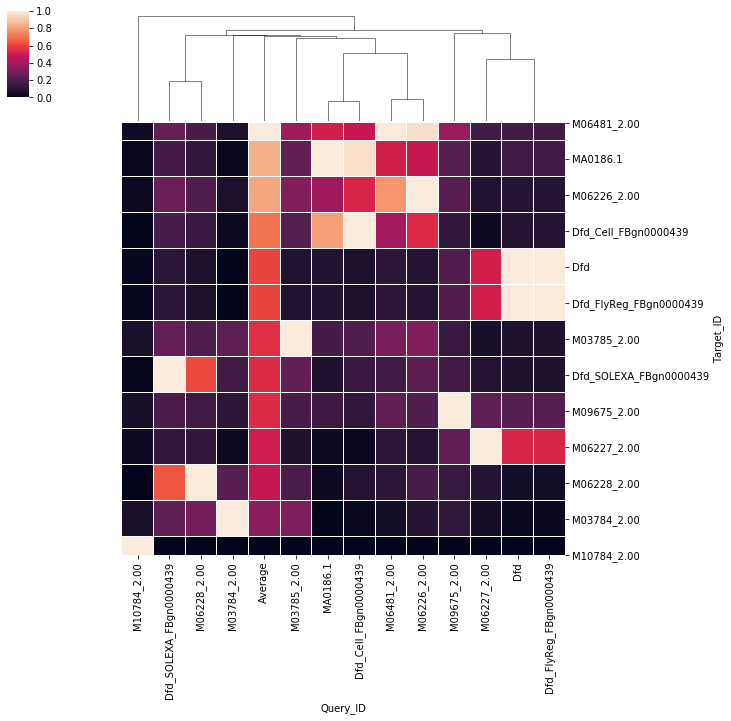

In [15]:
cg = sns.clustermap(tomtom_normalized, method='single', metric="euclidean", row_cluster=False, linewidths=.15, standard_scale=1)
cg
#test = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
#test = plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)

### Run FISim analysis

In [16]:

import run_fisim

/home/festo/Documents/MARStool/MARS-Update-Pipeline/Evaluation/run_fisim.py:68: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  fisim_df = fisim_df.T.ix[:-1].T


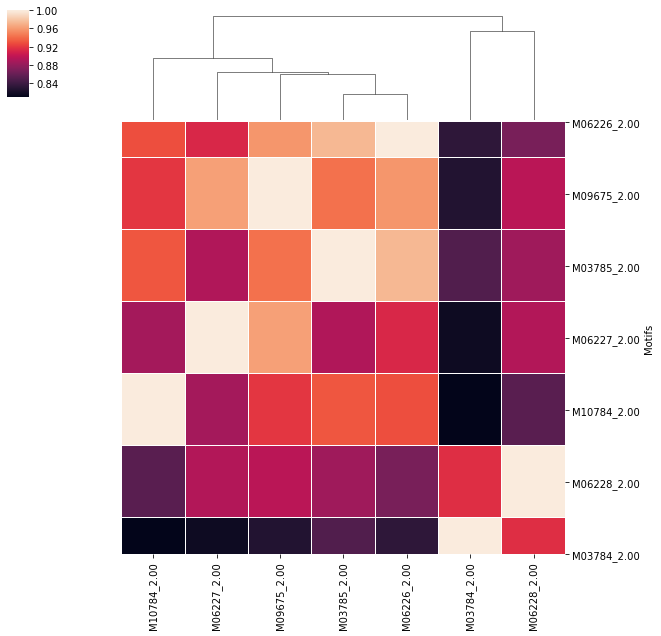

In [20]:
BASE_DIR = !pwd
BASE_DIR = BASE_DIR[0]
tf_name = tf
meme_in = '%s/Results/%s.meme' % (BASE_DIR, tf)
results_path = "%s/Evaluation/Results" % BASE_DIR
#Set figure to True to get it inline
run_fisim.run_fisim(tf_name, meme_in, results_path, figure=True)

## Scoring and classification motif assessement and ranking